# __WOA7015 Alternative Assessment__
Group: __Learning Machine__

Final Model

## Import Needed Modules

In [1]:
import torch
import time
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision.models import resnet18, VGG16_Weights, ResNet18_Weights, AlexNet_Weights
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report
)
import pandas as pd
import logging
from datetime import datetime
import math
from typing import Optional, Tuple, List, Dict, Any
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.tensorboard import SummaryWriter
import io
import seaborn as sns
import logging
from io import BytesIO
from PIL import Image
import csv
import pandas as pd 

In [2]:
# Set the device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Get Data

In [3]:
# Baseline: RGB
train_data_dataloader_baseline = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))
    ], p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_data_dataloader_baseline = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom: RGB
train_data_dataloader = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([
        transforms.RandomRotation(degrees=15),
        # transforms.ColorJitter(brightness=0.2, contrast=0.2),
        # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))
    ], p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_data_dataloader = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom: Gray
train_data_dataloader_gry = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([
        transforms.RandomRotation(degrees=15),
        # transforms.ColorJitter(brightness=0.2, contrast=0.2),
        # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))
    ], p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_data_dataloader_gry = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# dataset: https://drive.google.com/drive/folders/1d1ArqNswahfsmP6h-fm3WCvL47dVOpxA?usp=drive_link

# Define the base directory for data
base_data_dir = '/kaggle/input/brain-tumor-mri-dataset'

# 1. Baseline: RGB
train_dataset_base = ImageFolder(f'{base_data_dir}/Training', transform=train_data_dataloader_baseline)
train_loader_base = DataLoader(train_dataset_base, batch_size=128, shuffle=True)  # batch_size set to 128 due to "CUDA out of memory" when using VGG16 model

val_dataset_base = ImageFolder(f'{base_data_dir}/Testing', transform=val_data_dataloader_baseline)
val_loader_base = DataLoader(val_dataset_base, batch_size=128, shuffle=False)

# 2. Custom: RGB
train_dataset = ImageFolder(f'{base_data_dir}/Training', transform=train_data_dataloader)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

val_dataset = ImageFolder(f'{base_data_dir}/Testing', transform=val_data_dataloader)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

# 3. Custom: Gray
train_dataset_gry = ImageFolder(f'{base_data_dir}/Training', transform=train_data_dataloader_gry)
train_loader_gry = DataLoader(train_dataset_gry, batch_size=256, shuffle=True)

val_dataset_gry = ImageFolder(f'{base_data_dir}/Testing', transform=val_data_dataloader_gry)
val_loader_gry = DataLoader(val_dataset_gry, batch_size=256, shuffle=False)


## Custom Architecture

In [4]:
class EfficientMultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be divisible by number of heads"

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5

        # Use a single projection for QKV to reduce computation
        self.qkv_proj = nn.Linear(embed_dim, 3 * embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        B, L, C = x.shape

        # Efficient QKV projection
        qkv = self.qkv_proj(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: t.view(B, L, self.num_heads, self.head_dim).transpose(1, 2), qkv)

        # Use einsum for more efficient attention computation
        attn_weights = torch.einsum('bhqd,bhkd->bhqk', q, k) * self.scale

        if mask is not None:
            attn_weights = attn_weights.masked_fill(mask == 0, float('-inf'))

        attn_probs = F.softmax(attn_weights, dim=-1)
        attn_probs = self.dropout(attn_probs)

        context = torch.einsum('bhqk,bhkd->bhqd', attn_probs, v)
        context = context.transpose(1, 2).contiguous().view(B, L, C)

        return self.out_proj(context)

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.05):
        super().__init__()
        self.attention = EfficientMultiHeadAttention(embed_dim, num_heads, dropout)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            #nn.Dropout(dropout),
        )

    def forward(self, x):
        x = x + self.attention(x)
        x = x + self.mlp(x)
        return x

class RotaryPositionalEmbedding(nn.Module):
    def __init__(self, dim, base=10000):
        super().__init__()
        inv_freq = 1. / (base ** (torch.arange(0., dim, 2.) / dim))
        self.register_buffer('inv_freq', inv_freq)

    def forward(self, x, seq_dim=1):
        t = torch.arange(x.shape[seq_dim], device=x.device).type_as(self.inv_freq)
        sinusoid_inp = torch.einsum("i,j->ij", t, self.inv_freq)
        emb = torch.cat((sinusoid_inp.sin(), sinusoid_inp.cos()), dim=-1)
        return emb[None, :, :]

class HybridFPNTransformer_gry(nn.Module):
    def __init__(self, num_classes, image_size=224, patch_size=16,
                 embed_dim=128, num_heads=8, transformer_depth=4):
        super().__init__()
        
        # Stem network remains the same - processes raw images
        self.stem = nn.Sequential(
            nn.Conv2d(1, embed_dim*2, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(embed_dim*2),
            nn.ReLU(inplace=True),
            nn.Conv2d(embed_dim*2, embed_dim, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(embed_dim),
            nn.ReLU(inplace=True)
        )

        # Patch embedding remains the same
        self.patch_embed = nn.Conv2d(
            embed_dim, embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

        # Rotary positional embeddings for spatial awareness
        self.rotary_emb = RotaryPositionalEmbedding(embed_dim)

        # Transformer blocks remain unchanged
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, embed_dim)
            for _ in range(transformer_depth)
        ])

        # Simplified classification head - directly from transformer output
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(embed_dim, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # Initial feature extraction
        x = self.stem(x)
        x_patches = self.patch_embed(x)

        # Reshape for transformer processing
        B, C, H, W = x_patches.shape
        x_patches = x_patches.flatten(2).transpose(1, 2)

        # Add positional information
        rotary_pos_emb = self.rotary_emb(x_patches)
        x_patches = x_patches + rotary_pos_emb

        # Process through transformer blocks
        for transformer_block in self.transformer_blocks:
            x_patches = transformer_block(x_patches)

        # Reshape back to 2D and classify
        x_transformed = x_patches.transpose(1, 2).view(B, -1, H, W)
        return self.classifier(x_transformed)


class HybridFPNTransformer(nn.Module):
    def __init__(self, num_classes, image_size=224, patch_size=16,
                 embed_dim=128, num_heads=8, transformer_depth=4):
        super().__init__()
        
        # Stem network remains the same - processes raw images
        self.stem = nn.Sequential(
            nn.Conv2d(3, embed_dim*2, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(embed_dim*2),
            nn.ReLU(inplace=True),
            nn.Conv2d(embed_dim*2, embed_dim, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(embed_dim),
            nn.ReLU(inplace=True)
        )

        # Patch embedding remains the same
        self.patch_embed = nn.Conv2d(
            embed_dim, embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

        # Rotary positional embeddings for spatial awareness
        self.rotary_emb = RotaryPositionalEmbedding(embed_dim)

        # Transformer blocks remain unchanged
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, embed_dim)
            for _ in range(transformer_depth)
        ])

        # Simplified classification head - directly from transformer output
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(embed_dim, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # Initial feature extraction
        x = self.stem(x)
        x_patches = self.patch_embed(x)

        # Reshape for transformer processing
        B, C, H, W = x_patches.shape
        x_patches = x_patches.flatten(2).transpose(1, 2)

        # Add positional information
        rotary_pos_emb = self.rotary_emb(x_patches)
        x_patches = x_patches + rotary_pos_emb

        # Process through transformer blocks
        for transformer_block in self.transformer_blocks:
            x_patches = transformer_block(x_patches)

        # Reshape back to 2D and classify
        x_transformed = x_patches.transpose(1, 2).view(B, -1, H, W)
        return self.classifier(x_transformed)

## Inference Code + Plotting ALL the Metrics

### To run the code correctly , must change the file path to trained model 

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-5-d5f658f0d730>:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions


Model: VGG16
Overall F1 Score: 99.77%
Overall Precision: 99.77%
Overall Recall: 99.77%
Overall Specificity: 99.93%
Parameters: 134.28M
Average Inference Time: 105.98 ms

Class-wise metrics:

Class 0:
Precision: 100.00%
Recall: 99.33%
Specificity: 100.00%

Class 1:
Precision: 99.03%
Recall: 100.00%
Specificity: 99.70%

Class 2:
Precision: 100.00%
Recall: 100.00%
Specificity: 100.00%

Class 3:
Precision: 100.00%
Recall: 99.67%
Specificity: 100.00%


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-5-d5f658f0d730>:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions


Model: Alexnet
Overall F1 Score: 99.31%
Overall Precision: 99.32%
Overall Recall: 99.31%
Overall Specificity: 99.78%
Parameters: 57.02M
Average Inference Time: 2.42 ms

Class-wise metrics:

Class 0:
Precision: 100.00%
Recall: 97.67%
Specificity: 100.00%

Class 1:
Precision: 97.76%
Recall: 99.67%
Specificity: 99.30%

Class 2:
Precision: 99.75%
Recall: 100.00%
Specificity: 99.89%

Class 3:
Precision: 99.67%
Recall: 99.67%
Specificity: 99.90%


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-5-d5f658f0d730>:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions


Model: Resnet18
Overall F1 Score: 99.70%
Overall Precision: 99.70%
Overall Recall: 99.69%
Overall Specificity: 99.91%
Parameters: 11.18M
Average Inference Time: 17.13 ms

Class-wise metrics:

Class 0:
Precision: 100.00%
Recall: 99.00%
Specificity: 100.00%

Class 1:
Precision: 98.71%
Recall: 100.00%
Specificity: 99.60%

Class 2:
Precision: 100.00%
Recall: 100.00%
Specificity: 100.00%

Class 3:
Precision: 100.00%
Recall: 99.67%
Specificity: 100.00%


<ipython-input-5-d5f658f0d730>:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)



Model: Custom_Transformer
Overall F1 Score: 98.47%
Overall Precision: 98.48%
Overall Recall: 98.47%
Overall Specificity: 99.51%
Parameters: 4.84M
Average Inference Time: 72.12 ms

Class-wise metrics:

Class 0:
Precision: 98.31%
Recall: 97.00%
Specificity: 99.51%

Class 1:
Precision: 96.76%
Recall: 97.71%
Specificity: 99.00%

Class 2:
Precision: 99.26%
Recall: 99.51%
Specificity: 99.67%

Class 3:
Precision: 99.33%
Recall: 99.33%
Specificity: 99.80%


<ipython-input-5-d5f658f0d730>:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)



Model: Custom_Transformer_GRY
Overall F1 Score: 97.86%
Overall Precision: 97.89%
Overall Recall: 97.86%
Overall Specificity: 99.32%
Parameters: 4.83M
Average Inference Time: 4.58 ms

Class-wise metrics:

Class 0:
Precision: 98.60%
Recall: 94.00%
Specificity: 99.60%

Class 1:
Precision: 94.92%
Recall: 97.71%
Specificity: 98.41%

Class 2:
Precision: 99.26%
Recall: 99.51%
Specificity: 99.67%

Class 3:
Precision: 98.36%
Recall: 99.67%
Specificity: 99.51%


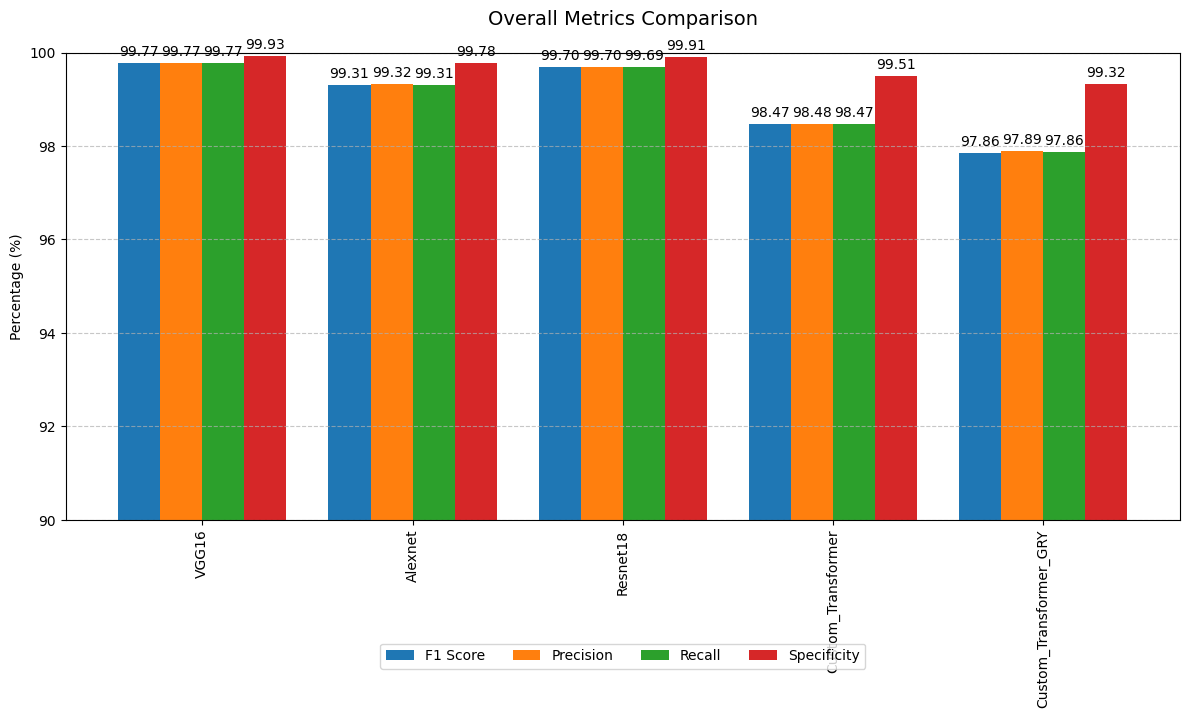

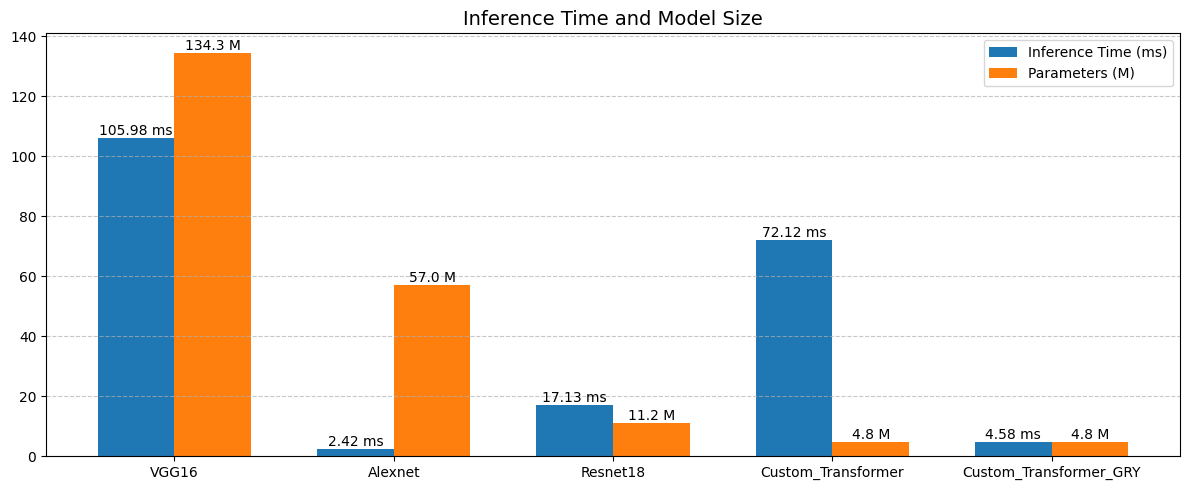

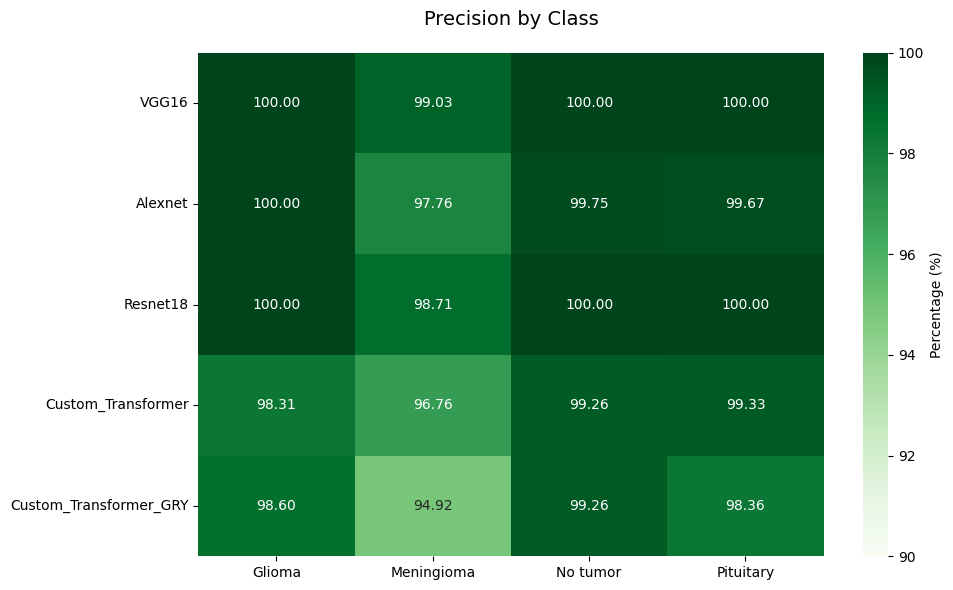

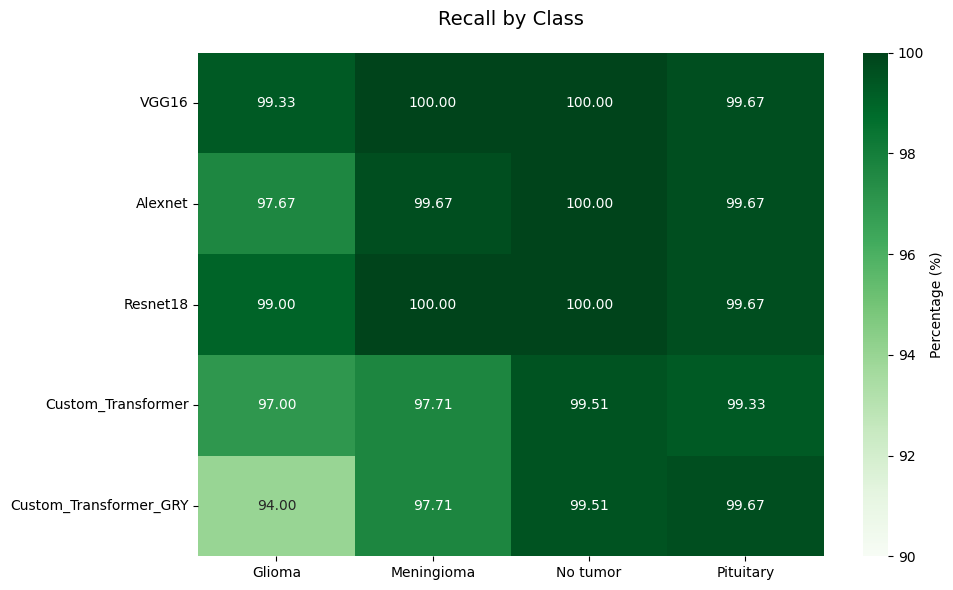

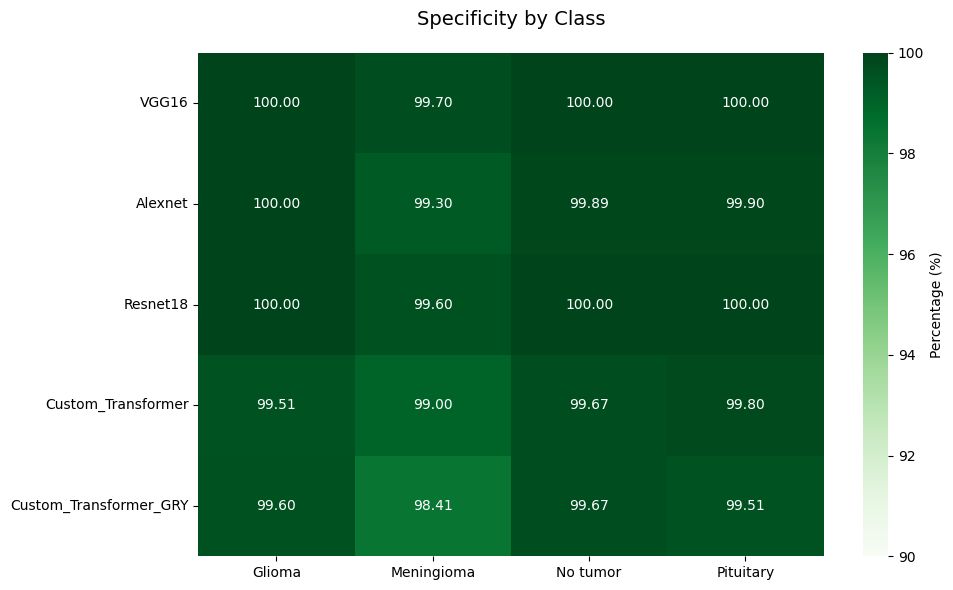

In [5]:
import os
import re
import time
import torch
import numpy as np
import torch.nn as nn
from torchvision import models
from sklearn.metrics import precision_recall_fscore_support, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def count_parameters(model):
    """Count number of trainable parameters"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def plot_inference_time_size(metrics_list):
    """Plot inference time and model size comparison"""
    model_names = [m['model_name'] for m in metrics_list]
    
    fig, ax = plt.subplots(figsize=(12, 5))
    x = np.arange(len(model_names))
    width = 0.35
    
    inference_times = [m['avg_inference_time'] * 1000 for m in metrics_list]
    param_sizes = [m['param_size']/1e6 for m in metrics_list]
    
    bars1 = ax.bar(x - width/2, inference_times, width, label='Inference Time (ms)')
    bars2 = ax.bar(x + width/2, param_sizes, width, label='Parameters (M)')
    
    ax.set_title('Inference Time and Model Size', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(model_names)
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    ax.bar_label(bars1, fmt='%.2f ms')
    ax.bar_label(bars2, fmt='%.1f M')
    
    plt.tight_layout()
    plt.savefig('inference_time_size.png', bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()
    
def evaluate_model(model_path, dataloader, device):
    """
    Evaluate model and return inference time, predictions, labels and model object
    """
    # Determine the model architecture based on the file path
    if "VGG16" in model_path:
        model = models.vgg16(pretrained=False)
        model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 4)
    elif "ResNet18" in model_path:
        model = models.resnet18(pretrained=False)
        model.fc = nn.Linear(model.fc.in_features, 4)
    elif "AlexNet" in model_path:
        model = models.alexnet(pretrained=False)
        model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 4)
    elif "TransformerGRY" in model_path:
        model = HybridFPNTransformer_gry(num_classes=4)
    else:
        model = HybridFPNTransformer(num_classes=4)

    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []
    inference_times = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            start_time = time.time()
            outputs = model(images)
            end_time = time.time()
            
            inference_times.append(end_time - start_time)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_inference_time = np.mean(inference_times)
    return avg_inference_time, np.array(all_labels), np.array(all_preds), model

def calculate_specificity(y_true, y_pred, num_classes):
    """Calculate specificity for multi-class classification"""
    specificities = []
    for class_idx in range(num_classes):
        # Create binary labels for current class
        y_true_binary = (y_true == class_idx)
        y_pred_binary = (y_pred == class_idx)
        
        # Calculate confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_true_binary, y_pred_binary).ravel()
        
        # Calculate specificity (true negative rate)
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificities.append(specificity)
    
    # Calculate overall specificity as weighted average
    weights = np.bincount(y_true) / len(y_true)
    overall_specificity = np.average(specificities, weights=weights)
    
    return overall_specificity, np.array(specificities)

def calculate_metrics(labels, predictions, num_classes):
    """Calculate metrics for the model"""
    # Calculate class-wise metrics
    precision_class, recall_class, f1_class, _ = precision_recall_fscore_support(
        labels, predictions, 
        average=None, 
        labels=range(num_classes),
        zero_division=0
    )
    
    # Calculate overall metrics using weighted average
    precision_overall, recall_overall, f1_overall, _ = precision_recall_fscore_support(
        labels, predictions, 
        average='weighted',
        zero_division=0
    )
    
    # Calculate specificity
    specificity_overall, specificity_class = calculate_specificity(labels, predictions, num_classes)
    
    return {
        'f1_overall': f1_overall,
        'f1_class': f1_class,
        'precision_class': precision_class,
        'precision_overall': precision_overall,
        'recall_class': recall_class,
        'recall_overall': recall_overall,
        'specificity_class': specificity_class,
        'specificity_overall': specificity_overall
    }

def plot_overall_metrics(metrics_list):
    """Plot overall metrics comparison with legend at the bottom"""
    model_names = [m['model_name'] for m in metrics_list]
    
    fig, ax = plt.subplots(figsize=(12, 7))
    
    overall_metrics = {
        'F1 Score': [m['metrics']['f1_overall'] * 100 for m in metrics_list],
        'Precision': [m['metrics']['precision_overall'] * 100 for m in metrics_list],
        'Recall': [m['metrics']['recall_overall'] * 100 for m in metrics_list],
        'Specificity': [m['metrics']['specificity_overall'] * 100 for m in metrics_list]
    }
    
    df_overall = pd.DataFrame(overall_metrics, index=model_names)
    bars = df_overall.plot(kind='bar', ax=ax, width=0.8)
    
    ax.set_title('Overall Metrics Comparison', pad=20, fontsize=14)
    ax.set_ylabel('Percentage (%)')
    ax.set_ylim(90, 100)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    for container in bars.containers:
        ax.bar_label(container, fmt='%.2f', padding=3)
    
    plt.legend(bbox_to_anchor=(0.5, -0.25),
              loc='upper center',
              ncol=4,
              bbox_transform=ax.transAxes)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.25)
    plt.savefig('overall_metrics.png', bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

def plot_metrics(metrics_list):
    """Generate all plots as separate images"""
    # Plot overall metrics
    plot_overall_metrics(metrics_list)
    
    # Plot inference time and model size
    plot_inference_time_size(metrics_list)
    
    # Plot class-wise metrics
    metrics_to_plot = [
        ('Precision', 'precision_class'),
        ('Recall', 'recall_class'),
        ('Specificity', 'specificity_class')
    ]
    
    for metric_name, metric_key in metrics_to_plot:
        plot_class_metric(metrics_list, metric_name, metric_key)

def plot_class_metric(metrics_list, metric_name, metric_key):
    """Plot class-wise metric heatmap"""
    model_names = [m['model_name'] for m in metrics_list]
    class_names = ['Glioma', 'Meningioma', 'No tumor', 'Pituitary']
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    data = np.array([m['metrics'][metric_key] * 100 for m in metrics_list])
    df = pd.DataFrame(data, columns=class_names, index=model_names)
    
    sns.heatmap(df, 
                annot=True, 
                cmap='Greens',
                fmt='.2f',
                cbar_kws={'label': 'Percentage (%)'},
                ax=ax,
                vmin=90,
                vmax=100)
    
    ax.set_title(f'{metric_name} by Class', pad=20, fontsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    
    plt.tight_layout()
    plt.savefig(f'{metric_name.lower().replace(" ", "_")}_by_class.png', bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()


def inference():
    highest_f1_files = [
        {'file': '/kaggle/input/inference/pytorch/default/1/best_VGG16_51_f1_0.9977.pth', 'loader': val_loader_base},
        {'file': '/kaggle/input/inference/pytorch/default/1/best_AlexNet_53_f1_0.9931.pth', 'loader': val_loader_base},
        {'file': '/kaggle/input/inference/pytorch/default/1/best_ResNet18_50_f1_0.9970.pth', 'loader': val_loader_base},
        {'file': '/kaggle/input/transformer/pytorch/default/1/Transformer_49_f1_0.9847.pth', 'loader': val_loader},
        {'file': '/kaggle/input/transformer/pytorch/default/1/TransformerGRY_68_f1_0.9786.pth', 'loader': val_loader_gry}
    ]

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    metrics_list = []
    model_names = ['VGG16','Alexnet','Resnet18','Custom_Transformer','Custom_Transformer_GRY']

    for i,item in enumerate(highest_f1_files):
        model_path = item["file"]
        dataloader = item["loader"]
        
        model_name = model_names[i]
        
        avg_inference_time, labels, predictions, model = evaluate_model(model_path, dataloader, device)
        metrics = calculate_metrics(labels, predictions, num_classes=4)
        param_size = count_parameters(model)
        
        metrics_list.append({
            'model_name': model_name,
            'metrics': metrics,
            'avg_inference_time': avg_inference_time,
            'param_size': param_size
        })
        
        print(f"\nModel: {model_name}")
        print(f"Overall F1 Score: {metrics['f1_overall']*100:.2f}%")
        print(f"Overall Precision: {metrics['precision_overall']*100:.2f}%")
        print(f"Overall Recall: {metrics['recall_overall']*100:.2f}%")
        print(f"Overall Specificity: {metrics['specificity_overall']*100:.2f}%")
        print(f"Parameters: {param_size/1e6:.2f}M")
        print(f"Average Inference Time: {avg_inference_time*1000:.2f} ms")
        
        # Print class-wise metrics
        print("\nClass-wise metrics:")
        for i in range(4):
            print(f"\nClass {i}:")
            print(f"Precision: {metrics['precision_class'][i]*100:.2f}%")
            print(f"Recall: {metrics['recall_class'][i]*100:.2f}%")
            print(f"Specificity: {metrics['specificity_class'][i]*100:.2f}%")

    plot_metrics(metrics_list)


inference()